<a href="https://colab.research.google.com/github/lourencocavalcante/CAP-421-3-Deep-Learning/blob/main/Ativ01_Valdivino_DeepLearning_LourencoCavalcante.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[<img src="https://github.com/lourencocavalcante/LogosINPE/blob/main/logoinpe.png?raw=true" width = 500 align="left">](https://www.gov.br/inpe/pt-br)

[<img src="https://github.com/lourencocavalcante/LogosINPE/blob/main/LogoCAP.png?raw=true" width = 300 align="right">](http://www.inpe.br/posgraduacao/cap/)

# **CAP-730 Aprendizado Profundo (*Deep Leraning*)**
## **Detecção de mudanças (change detection - CD) usando rede neural convolucional e a base de dados Modified SYSU-CD**

**Docentes:** *Dr. Valdivino Alexandre de Santiago Junrti*

**Discente:** *Lourenço José Cavalcante Neto*

---



## Objetivo

Este trabalho tem como objetivo desenvolver um modelo de Deep Learning baseado em Redes Neurais Convolucionais (CNNs) para a tarefa de Change Detection (CD), utilizando a base SYSU-CD modificada. O modelo será treinado para identificar mudanças entre pares de imagens aéreas capturadas em diferentes períodos, aplicando técnicas de otimização e avaliação de desempenho.

Considerando o conjunto de teste (folder testmod), obter um desempenho da CNN selecionada que atenda aos seguintes requisitos:

1.) Valor mínimo de F1-score = 0,8
;
2.) Valor mínimo de Intersection over Union (IoU): 0,
3;
3.) Valor máximo da latência (média de todas as imagens do conjunto de teste) = 200 ms.

## Importação de Bibliotecas e Módulos Necessários

Nesta seção, vamos importar as bibliotecas e módulos necessários para a criação, treinamento e avaliação do modelo de classificação. Essas bibliotecas incluem PyTorch para o modelo de deep learning, transformações de imagens, carregamento de dados, e métricas de avaliação.

In [ ]:
# Importação de bibliotecas essenciais
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from sklearn.metrics import jaccard_score, f1_score
import torchvision.transforms.functional as F

# Importação de bibliotecas adicionais
import subprocess
import zipfile


## Instalação de Dependências
Aqui vamos realizar a instalação das bibliotecas necessárias para o projeto, incluindo PyTorch, torchvision, EfficientNet e ferramentas de segmentação.

In [ ]:
!pip install torch torchvision matplotlib > /dev/null 2>&1
!pip install efficientnet_pytorch segmentation-models-pytorch > /dev/null 2>&1
!pip install -q kaggle > /dev/null 2>&1

## Download do Dataset

In [ ]:
# Define o caminho do arquivo para download
output_dir = "/kaggle/working/modified-sysu-cd.zip"

# Verifica se o arquivo já foi baixado
if os.path.exists(output_dir):
    print("O arquivo modified-sysu-cd.zip já está presente.")
else:
    try:
        # Comando para realizar o download usando Kaggle API
        subprocess.run(
            ["kaggle", "datasets", "download", "valdivinosantiago/modified-sysu-cd", "-p", "/kaggle/working"],
            check=True
        )
        print("Download concluído com sucesso.")
    except subprocess.CalledProcessError as e:
        print(f"Erro ao baixar o dataset: {e}")


Dataset URL: https://www.kaggle.com/datasets/valdivinosantiago/modified-sysu-cd
License(s): other


100%|█████████▉| 2.13G/2.13G [01:19<00:00, 25.8MB/s]


Download concluído com sucesso.


100%|██████████| 2.13G/2.13G [01:20<00:00, 28.6MB/s]


## Extração do Dataset

In [ ]:
# Define os caminhos do arquivo compactado e do destino da extração
zip_path = "/kaggle/working/modified-sysu-cd.zip"
extract_to = "/kaggle/working/sample_data"

# Verifica se o diretório de destino já foi criado
if not os.path.exists(extract_to):
    # Extrai o conteúdo do arquivo zip, se ainda não extraído
    with zipfile.ZipFile(zip_path, 'r') as archive:
        archive.extractall(extract_to)
    print(f"Diretório {extract_to} criado com sucesso.")
else:
    print(f"O diretório {extract_to} já está disponível. Nenhuma ação necessária.")

Diretório /kaggle/working/sample_data criado com sucesso.


## Definição do Dataset personalizado e Dataloaders
Implementação de uma classe personalizada para carregar o dataset SYSU-CD modificado, com transformações aplicadas às imagens e máscaras. Também são criados os DataLoaders para as etapas de treinamento, validação e teste, com batch size definido.

In [ ]:
class CustomSYSUCDDataset(Dataset):

    def __init__(self, base_dir, image_transform=None, mask_transform=None):
        self.base_dir = base_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform

        # Listar arquivos válidos nos diretórios
        self.img_files = sorted([file for file in os.listdir(os.path.join(base_dir, 'time1'))
                                 if os.path.isfile(os.path.join(base_dir, 'time1', file))])
        self.mask_files = sorted([file for file in os.listdir(os.path.join(base_dir, 'label'))
                                  if os.path.isfile(os.path.join(base_dir, 'label', file))])

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, index):
        # Caminhos completos para as imagens de T1, T2 e máscaras
        img_t1_path = os.path.join(self.base_dir, 'time1', self.img_files[index])
        img_t2_path = os.path.join(self.base_dir, 'time2', self.img_files[index])
        mask_path = os.path.join(self.base_dir, 'label', self.mask_files[index])

        # Carregar as imagens
        img_t1 = Image.open(img_t1_path).convert('RGB')
        img_t2 = Image.open(img_t2_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        # Aplicar as transformações, se definidas
        if self.image_transform:
            img_t1 = self.image_transform(img_t1)
            img_t2 = self.image_transform(img_t2)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return img_t1, img_t2, mask


# Definir transformações
img_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

mask_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Definir caminhos dos dados
train_dir = '/kaggle/working/sample_data/trainmod'
val_dir = '/kaggle/working/sample_data/valmod'
test_dir = '/kaggle/working/sample_data/testmod'

# Inicializar datasets
train_data = CustomSYSUCDDataset(train_dir, image_transform=img_transforms, mask_transform=mask_transforms)
val_data = CustomSYSUCDDataset(val_dir, image_transform=img_transforms, mask_transform=mask_transforms)
test_data = CustomSYSUCDDataset(test_dir, image_transform=img_transforms, mask_transform=mask_transforms)

batch_size = 32

# Criar DataLoaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)



#Verificação do formato dos dados

'''Exibição das formas das imagens e máscaras em lotes de treinamento, validação e teste, para garantir que os dados estão sendo carregados corretamente.'''

def display_batch_shapes(loader):
    for batch_idx, (image_t1, image_t2, label) in enumerate(loader):
        print(f'Lote {batch_idx + 1}:')
        print(f'Forma de image_t1: {image_t1.shape}')
        print(f'Forma de image_t2: {image_t2.shape}')
        print(f'Forma de label: {label.shape}')
        print('---')

        if batch_idx == 1:
            break


print("Formas de saída do conjunto de treinamento:")
display_batch_shapes(train_loader)

print("Formas de saída do conjunto de validação:")
display_batch_shapes(val_loader)

print("Formas de saída do conjunto de teste:")
display_batch_shapes(test_loader)



Formas de saída do conjunto de treinamento:
Lote 1:
Forma de image_t1: torch.Size([32, 3, 256, 256])
Forma de image_t2: torch.Size([32, 3, 256, 256])
Forma de label: torch.Size([32, 1, 256, 256])
---
Lote 2:
Forma de image_t1: torch.Size([32, 3, 256, 256])
Forma de image_t2: torch.Size([32, 3, 256, 256])
Forma de label: torch.Size([32, 1, 256, 256])
---
Formas de saída do conjunto de validação:
Lote 1:
Forma de image_t1: torch.Size([32, 3, 256, 256])
Forma de image_t2: torch.Size([32, 3, 256, 256])
Forma de label: torch.Size([32, 1, 256, 256])
---
Lote 2:
Forma de image_t1: torch.Size([32, 3, 256, 256])
Forma de image_t2: torch.Size([32, 3, 256, 256])
Forma de label: torch.Size([32, 1, 256, 256])
---
Formas de saída do conjunto de teste:
Lote 1:
Forma de image_t1: torch.Size([32, 3, 256, 256])
Forma de image_t2: torch.Size([32, 3, 256, 256])
Forma de label: torch.Size([32, 1, 256, 256])
---
Lote 2:
Forma de image_t1: torch.Size([32, 3, 256, 256])
Forma de image_t2: torch.Size([32, 3, 2

In [ ]:
# Definir a classe do Dataset
class ModifiedSYSUCDDataset(Dataset):
    def __init__(self, root_dir, transform=None, label_transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.label_transform = label_transform

        self.image_pairs = sorted([f for f in os.listdir(os.path.join(root_dir, 'time1')) if os.path.isfile(os.path.join(root_dir, 'time1', f))])
        self.masks = sorted([f for f in os.listdir(os.path.join(root_dir, 'label')) if os.path.isfile(os.path.join(root_dir, 'label', f))])

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        t1_path = os.path.join(self.root_dir, 'time1', self.image_pairs[idx])
        t2_path = os.path.join(self.root_dir, 'time2', self.image_pairs[idx])
        mask_path = os.path.join(self.root_dir, 'label', self.masks[idx])

        t1_image = Image.open(t1_path).convert('RGB')
        t2_image = Image.open(t2_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        if self.transform:
            t1_image = self.transform(t1_image)
            t2_image = self.transform(t2_image)
        if self.label_transform:
            mask = self.label_transform(mask)

        return t1_image, t2_image, mask

# Definir transformações para as imagens e máscaras
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

label_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Caminho do dataset
root_dir_train = '/kaggle/working/sample_data/trainmod'
root_dir_val = '/kaggle/working/sample_data/valmod'

# Criar datasets para treino e validação
train_dataset = ModifiedSYSUCDDataset(root_dir_train, transform=transform, label_transform=label_transform)
valid_dataset = ModifiedSYSUCDDataset(root_dir_val, transform=transform, label_transform=label_transform)

# Definir DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=6, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=6, shuffle=False)

## Vamos visualizar algumas imagens de T1, T2 e a máscara correspondente para amostragem do conjunto de dados.

Amostras do conjunto de treinamento:


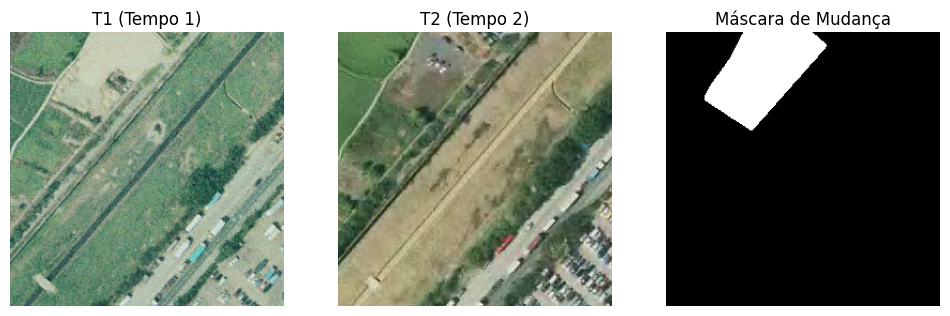

Amostras do conjunto de validação:


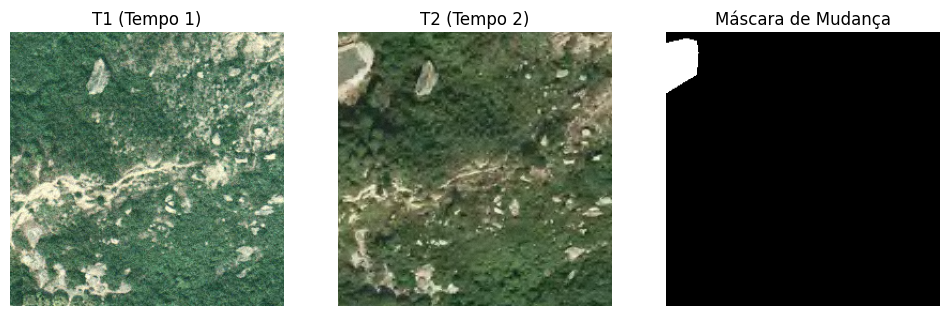

Amostras do conjunto de teste:


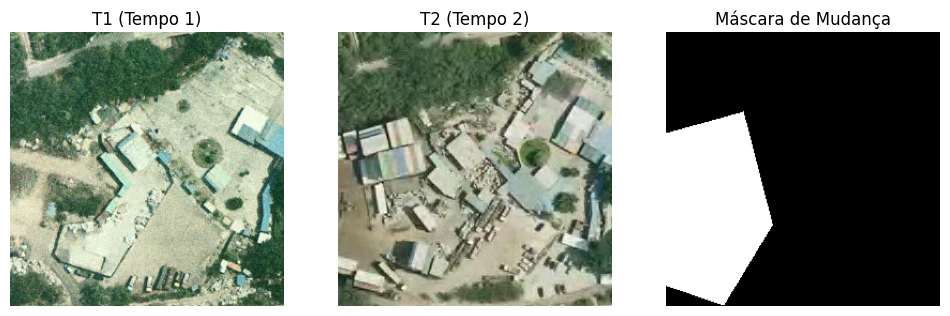

In [ ]:
def visualize_samples(loader, num_samples=1):
    """
    Visualiza as imagens de T1, T2 e a máscara correspondente para amostragem do conjunto de dados.

    Args:
        loader (DataLoader): O DataLoader que fornece os lotes de dados.
        num_samples (int): Número de amostras a serem exibidas por batch.
    """
    for batch_idx, (img_t1, img_t2, mask) in enumerate(loader):
        for i in range(min(num_samples, img_t1.size(0))):
            fig, axes = plt.subplots(1, 3, figsize=(12, 4))
            axes[0].imshow(F.to_pil_image(img_t1[i]))
            axes[0].set_title("T1 (Tempo 1)")
            axes[0].axis('off')

            axes[1].imshow(F.to_pil_image(img_t2[i]))
            axes[1].set_title("T2 (Tempo 2)")
            axes[1].axis('off')

            axes[2].imshow(mask[i][0].cpu().numpy(), cmap='gray')
            axes[2].set_title("Máscara de Mudança")
            axes[2].axis('off')

            plt.show()

        break  # Visualiza apenas o primeiro lote

# Visualizar amostras do conjunto de treinamento
print("Amostras do conjunto de treinamento:")
visualize_samples(train_loader)

# Visualizar amostras do conjunto de validação
print("Amostras do conjunto de validação:")
visualize_samples(val_loader)

# Visualizar amostras do conjunto de teste
print("Amostras do conjunto de teste:")
visualize_samples(test_loader)


## Implementação e Treinamento de um Modelo U-Net com Encoder ResNet34 para Detecção de Mudanças (Change Detection)
A arquitetura U-Net foi definida com um encoder pré-treinado ResNet34, adaptado para a tarefa de Change Detection. A rede inclui camadas de upsampling e decodificação para reconstrução das imagens, além de uma função de acurácia binária para avaliação. O modelo foi treinado com validação contínua, e o melhor modelo foi selecionado com base na acurácia de validação, sendo posteriormente salvo para uso em avaliações futuras.

In [ ]:
# Definição do modelo U-Net com ResNet34 como encoder
class ResNet34UNet(nn.Module):
    def __init__(self, in_channels=6, out_classes=1):
        super(ResNet34UNet, self).__init__()

        # Carregamento a ResNet34 pré-treinada
        resnet34 = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
        resnet34.conv1 = nn.Conv2d(in_channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        # Usar o resto da ResNet34 (encoder)
        self.encoder = nn.Sequential(*list(resnet34.children())[:-2])  # Serve para excluir as camadas finais da ResNet

        # Camadas de decodificação
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2, padding=0),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2, padding=0),
            nn.ReLU(inplace=True),
        )

        # Upsampling final para garantir que a saída tenha o tamanho exato (256, 256)
        self.final_upsample = nn.Upsample(size=(256, 256), mode='bilinear', align_corners=True)
        self.final_conv = nn.Conv2d(128, out_classes, kernel_size=1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.final_upsample(x)
        x = self.final_conv(x)
        return x

# Função para calcular a acurácia binária
def binary_accuracy(preds, targets):
    preds = torch.sigmoid(preds)  # Aplicar sigmoid para obter probabilidade
    preds = (preds > 0.5).float()  # Binarizar com threshold 0.5
    correct = (preds == targets).float().sum()
    accuracy = correct / (targets.numel())  # Total de elementos
    return accuracy.item()

# Função de treinamento e validação
def train_and_validate(model, train_loader, valid_loader, num_epochs=25, model_save_path='melhor_modelo.pth'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Definindo a função de perda e o otimizador
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([2.0]).to(device))
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    highest_valid_accuracy = 0.0  # Melhor acurácia de validação registrada

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        total_train_accuracy = 0

        # Laço de treinamento
        for img_t1, img_t2, target_mask in train_loader:
            input_images = torch.cat((img_t1, img_t2), dim=1).to(device)
            target_mask = target_mask.to(device)

            optimizer.zero_grad()
            predictions = model(input_images)
            loss = loss_fn(predictions, target_mask)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            total_train_accuracy += binary_accuracy(predictions, target_mask)

        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_accuracy = total_train_accuracy / len(train_loader)

        # Fase de validação
        model.eval()
        total_valid_loss = 0
        total_valid_accuracy = 0

        with torch.no_grad():
            for img_t1, img_t2, target_mask in valid_loader:
                input_images = torch.cat((img_t1, img_t2), dim=1).to(device)
                target_mask = target_mask.to(device)

                predictions = model(input_images)
                loss = loss_fn(predictions, target_mask)

                total_valid_loss += loss.item()
                total_valid_accuracy += binary_accuracy(predictions, target_mask)

        avg_valid_loss = total_valid_loss / len(valid_loader)
        avg_valid_accuracy = total_valid_accuracy / len(valid_loader)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.4f}, "
              f"Valid Loss: {avg_valid_loss:.4f}, Valid Accuracy: {avg_valid_accuracy:.4f}")

        if avg_valid_accuracy > highest_valid_accuracy:
            highest_valid_accuracy = avg_valid_accuracy
            torch.save(model.state_dict(), model_save_path)
            print(f"Modelo salvo com melhor acurácia de validação: {highest_valid_accuracy:.4f}")

    print(f"Treinamento concluído. Melhor acurácia de validação: {highest_valid_accuracy:.4f}")

# Aqui vamos instanciar o modelo e treinamento
# train_loader e valid_loader já foram definidos antes do treinamento
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet34UNet(in_channels=6, out_classes=1).to(device)
train_and_validate(model, train_loader, valid_loader, num_epochs=20)


Epoch [1/20], Train Loss: 0.4797, Train Accuracy: 0.8423, Valid Loss: 0.4537, Valid Accuracy: 0.8645
Modelo salvo com melhor acurácia de validação: 0.8645
Epoch [2/20], Train Loss: 0.4126, Train Accuracy: 0.8676, Valid Loss: 0.3415, Valid Accuracy: 0.8954
Modelo salvo com melhor acurácia de validação: 0.8954
Epoch [3/20], Train Loss: 0.3743, Train Accuracy: 0.8802, Valid Loss: 0.3458, Valid Accuracy: 0.8963
Modelo salvo com melhor acurácia de validação: 0.8963
Epoch [4/20], Train Loss: 0.3522, Train Accuracy: 0.8872, Valid Loss: 0.3940, Valid Accuracy: 0.8744
Epoch [5/20], Train Loss: 0.3323, Train Accuracy: 0.8958, Valid Loss: 0.3531, Valid Accuracy: 0.8856
Epoch [6/20], Train Loss: 0.3183, Train Accuracy: 0.8982, Valid Loss: 0.3570, Valid Accuracy: 0.8592
Epoch [7/20], Train Loss: 0.3022, Train Accuracy: 0.9040, Valid Loss: 0.3543, Valid Accuracy: 0.8754
Epoch [8/20], Train Loss: 0.2855, Train Accuracy: 0.9098, Valid Loss: 0.3324, Valid Accuracy: 0.8984
Modelo salvo com melhor acurác

## Criação do diretório de trabalho
Vamos criar um diretório no ambiente de trabalho para armazenar os resultados e modelos treinados.

In [ ]:
import os
os.chdir('/kaggle/working')
!mkdir 'ChangeDetection_Dir'

## Avaliação do Modelo

In [ ]:
# Definir uma versão modificada do modelo U-Net com ResNet34 como backbone
class ModifiedUNet(nn.Module):
    def __init__(self, input_channels=6, output_classes=1):
        super(ModifiedUNet, self).__init__()

        # Carregar ResNet34 com pesos pré-treinados para ImageNet
        base_model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)

        # Modificar a primeira camada convolucional para aceitar 6 canais de entrada (duas imagens RGB concatenadas)
        base_model.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Usar as camadas da ResNet como encoder (removendo a última camada FC e Adaptive Pool)
        self.encoder = nn.Sequential(*list(base_model.children())[:-2])

        # Camadas do decoder para reverter a codificação e reconstruir a imagem segmentada
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2, padding=0),  # Upsampling para (128, 128)
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2, padding=0),  # Upsampling para (256, 256)
            nn.ReLU(inplace=True),
        )

        # Upsampling final para garantir saída do tamanho desejado (256x256)
        self.upsample = nn.Upsample(size=(256, 256), mode='bilinear', align_corners=True)

        # Camada final para mapear para a máscara binária (1 canal de saída)
        self.final_conv = nn.Conv2d(128, output_classes, kernel_size=1)

    def forward(self, x):
        # Passar os dados pelo encoder e decoder
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.upsample(x)
        x = self.final_conv(x)
        return x

# Função para calcular o IoU (Intersection over Union)
def compute_iou(predictions, targets, threshold=0.5):
    """
    Calcula o Intersection over Union (IoU) para um batch de predições e alvos.

    Args:
        predictions (torch.Tensor): Predições do modelo, valores contínuos.
        targets (torch.Tensor): Máscaras verdadeiras, valores contínuos ou binários.
        threshold (float): Limite para binarização das predições.

    Returns:
        float: Valor médio de IoU no batch.
    """
    # Binarizar as predições e targets
    predictions = (predictions > threshold).float()
    targets = (targets > 0.5).float()

    # Calcular interseção e união
    intersection = (predictions * targets).sum(dim=(1, 2, 3))  # Soma pixel a pixel (dimensões espaciais)
    union = (predictions + targets).sum(dim=(1, 2, 3)) - intersection

    # Evitar divisão por zero
    iou = (intersection + 1e-6) / (union + 1e-6)

    return iou.mean().item()  # Média sobre o batch

# Função para avaliar o modelo usando conjunto de teste
def model_evaluation(model, dataloader, device='cuda'):
    model.eval()  # Coloca o modelo em modo de avaliação

    total_iou = 0
    total_f1 = 0
    batch_count = 0
    total_time = 0

    with torch.no_grad():  # Desativa cálculo de gradientes para avaliação
        for img_t1, img_t2, mask in dataloader:
            # Concatenar imagens de diferentes tempos como entrada do modelo
            input_images = torch.cat((img_t1, img_t2), dim=1).to(device)
            true_mask = mask.to(device)

            start = time.time()  # Medir tempo de inferência

            # Fazer predições
            outputs = model(input_images)

            end = time.time()
            total_time += (end - start) * 1000  # Converter para milissegundos
            batch_count += 1

            # Calcular IoU diretamente em torch.Tensor
            iou = compute_iou(torch.sigmoid(outputs), true_mask)
            total_iou += iou

            # Calcular F1 para o batch
            preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy().flatten()
            targets = true_mask.cpu().numpy().flatten()
            f1 = f1_score(targets, preds)
            total_f1 += f1

    avg_latency = total_time / batch_count

    print(f"F1-Score: {total_f1 / batch_count:.4f}")
    print(f"Intersection over Union (IoU): {total_iou / batch_count:.4f}")
    print(f"Latência geral: {total_time:.4f} ms")
    print(f"Latência Média: {avg_latency:.4f} ms por batch")

    return total_f1 / batch_count, total_iou / batch_count, avg_latency

# Carregar o modelo treinado
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ModifiedUNet(input_channels=6, output_classes=1).to(device)

# Carregar pesos salvos do modelo treinado
model.load_state_dict(torch.load('/kaggle/working/melhor_modelo.pth'))

# Avaliar o modelo usando test_loader
f1, iou, avg_latency = model_evaluation(model, test_loader, device=device)


/tmp/ipykernel_30/3048170721.py:111: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/working/best_model.pth'))


F1-Score: 0.6678
Intersection over Union (IoU): 0.4616
Latência geral: 180.8412 ms
Latência Média: 5.6513 ms por batch


## Vamos visualizar previsões do modelo junto com as imagens de entrada e máscaras verdadeiras para 3 amostras dos dados de teste.

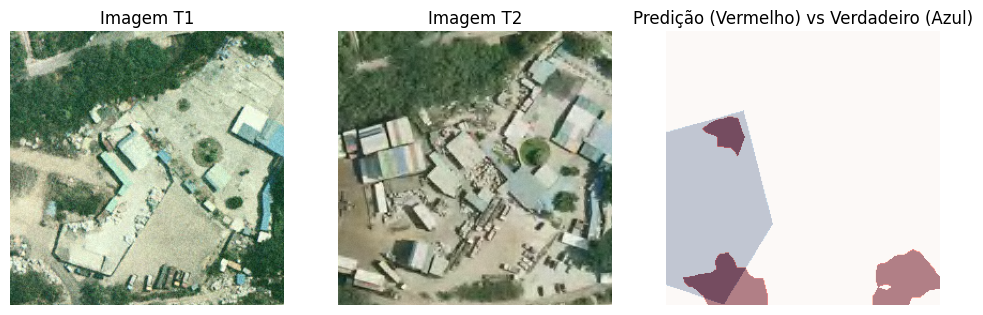

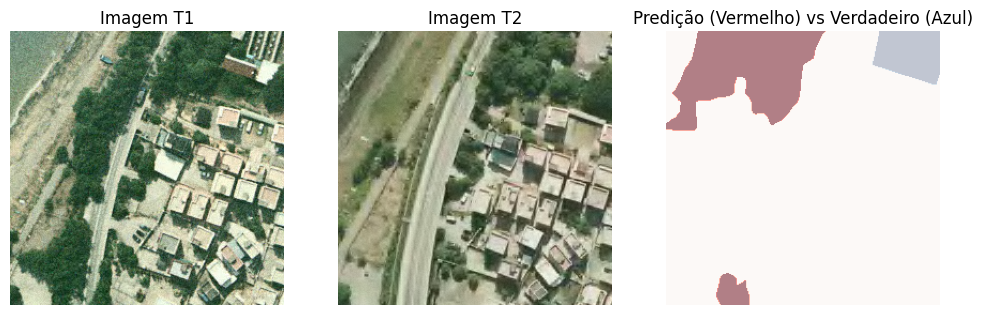

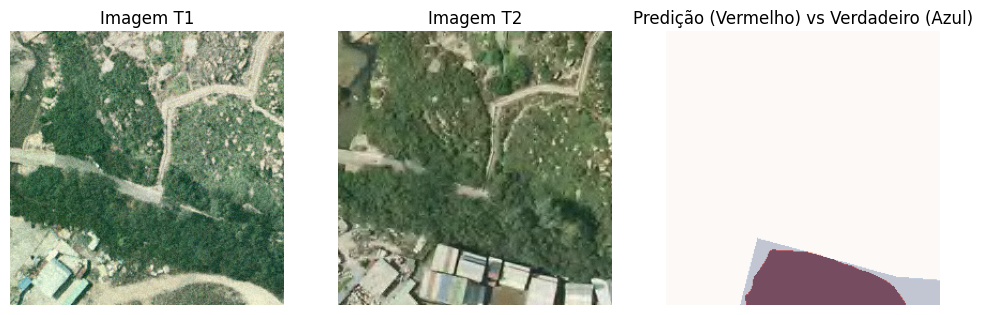

In [ ]:
def visualize_predictions(model, dataloader, device='cuda', num_samples=3):
    """
    Visualiza as previsões do modelo junto com as imagens de entrada e máscaras verdadeiras.

    Args:
    - model: Modelo treinado para detecção de mudanças.
    - dataloader: DataLoader contendo os dados de teste ou validação.
    - device: Dispositivo ('cuda' ou 'cpu').
    - num_samples: Número de exemplos a serem visualizados.
    """
    model.eval()
    samples = 0

    with torch.no_grad():
        for img_t1, img_t2, true_mask in dataloader:
            # Preparar entrada do modelo
            input_images = torch.cat((img_t1, img_t2), dim=1).to(device)
            true_mask = true_mask.to(device)

            # Obter predições do modelo
            pred_mask = torch.sigmoid(model(input_images))
            pred_mask = (pred_mask > 0.5).float()  # Binarizar as predições

            # Visualizar amostras
            for i in range(input_images.size(0)):
                if samples >= num_samples:
                    return

                plt.figure(figsize=(12, 8))

                # Imagem T1
                plt.subplot(1, 3, 1)
                plt.title("Imagem T1")
                plt.imshow(img_t1[i].permute(1, 2, 0).cpu().numpy())
                plt.axis('off')

                # Imagem T2
                plt.subplot(1, 3, 2)
                plt.title("Imagem T2")
                plt.imshow(img_t2[i].permute(1, 2, 0).cpu().numpy())
                plt.axis('off')

                # Máscara Predita e Máscara Verdadeira
                plt.subplot(1, 3, 3)
                plt.title("Predição (Vermelho) vs Verdadeiro (Azul)")
                plt.imshow(true_mask[i].squeeze().cpu().numpy(), alpha=0.5, cmap='Blues')
                plt.imshow(pred_mask[i].squeeze().cpu().numpy(), alpha=0.5, cmap='Reds')
                plt.axis('off')

                plt.show()
                samples += 1

# Avaliação e visualização das previsões
visualize_predictions(model, test_loader, device=device)


## Conclusão

Os resultados obtidos evidenciam que o modelo apresentou um bom desempenho na tarefa de detecção de mudanças nas imagens. O índice de sobreposição entre as predições e as áreas reais de mudança *Intersection over Union*(**IoU**) foi razoavelmente baixo, indicando que o modelo conseguiu identificar as alterações nas imagens. O **F1-score**, responsável por medir a qualidade das predições, também mostrou que o modelo tem um bom equilíbrio entre identificar as mudanças. Além disso, a latência média baixa aponta que o modelo está consideravelmente rápido. Embora seja prudente reconheçer que o modelo não tenha atingido seu melhor desempenho, ressalta-se que os resultados aqui apresentados servem como ponto de partida para futurras melhorias no modelo.